In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


/home/iai/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# Define transforms for dataset
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
original_dataset_dir = '/home/iai/Desktop/bsh/active_learning/data/mvtec2'
classes_list = os.listdir(original_dataset_dir)

train_dataset = ImageFolder(root='/home/iai/Desktop/bsh/active_learning/data/splitted2/train', transform=transform)
test_dataset = ImageFolder(root='/home/iai/Desktop/bsh/active_learning/data/splitted2/test', transform=transform)

print(len(train_dataset))
print(len(test_dataset))

print(len(classes_list))

4282
1072
2


In [3]:
#Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Define loss function and optimizer
BATCH_SIZE = 4
EPOCHS = 35

criterion = nn.CrossEntropyLoss()

train_loss_list = []

def train(model, train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0.0
    for _,(image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    #train_loss_list.append(train_loss)
    
    return train_loss

In [5]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc

test_acc_list = []
test_loss_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []
test_auc_list = []
test_fpr_list = []
test_tpr_list = []

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    
    with torch.no_grad():
      n_samples = 0
      y_true = []
      y_pred = []
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          output = model(images)
          test_loss += criterion(output, labels).item()
          _, predicted = torch.max(output,1)
          n_samples += labels.size(0)
          test_accuracy += (predicted == labels).sum().item()
          y_true.extend(labels.tolist())
          y_pred.extend(predicted.tolist())        
      test_accuracy /= n_samples
      test_loss /= len(test_loader)
      # test_acc_list.append(test_accuracy/n_samples * 100.)
      # test_loss_list.append(len(test_loader) * 100.)

      precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'binary', zero_division=1)
      cm = confusion_matrix(y_true, y_pred)
      print("Confusion Matrix")
      print(cm)
      # TN FP
      # FN TP
      test_precision_list.append(precision)
      test_recall_list.append(recall)
      test_f1_list.append(f1)
      print(f"Test Precision: {precision.item():.4f}, Test Recall: {recall.item():.4f}, Test F1 Score: {f1.item():.4f}")

      # Compute AUC score and ROC curve
      fpr, tpr, thresholds = roc_curve(y_true, y_pred)
      roc_auc = auc(fpr, tpr)
      auc_score = roc_auc_score(y_true, y_pred)
      # test_auc_list.append(auc_score)
      test_fpr_list.append(fpr)
      test_tpr_list.append(tpr)
      # print(f"AUC Score: {auc_score:.4f}")

    return test_loss, test_accuracy, auc_score, f1

In [6]:
# Pretrained : 미리 학습된 resnet18모델을 불러온 후 이미지 데이터에 맞게 Fine Tuning

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
# Because num of class is 2
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [7]:
for EPOCH in range(EPOCHS):
    train(model, train_loader,optimizer, log_interval = 5)
    train_loss = train(model, train_loader,optimizer, log_interval = 5)
    train_loss_list.append(train_loss)
    print("[EPOCH:{}],\tTrain Loss: {:.4f},".format(EPOCH+1, train_loss))

test_loss, test_accuracy, auc_score, f1 = evaluate(model, test_loader)
test_acc_list.append(test_accuracy)
test_loss_list.append(test_loss)
test_auc_list.append(auc_score)
test_f1_list.append(f1)
print("-------------------------------------------------------------------")
print(f"Test F1 Score: {f1}")
print("[EPOCH:{}],\tTest Loss: {:.4f}, \tTest Accuracy:{:.4f},\tAUC_score: {:.4f}".format(EPOCHS, test_loss, test_accuracy, auc_score))
print("-------------------------------------------------------------------")

[EPOCH:1],	Train Loss: 0.5432,
[EPOCH:2],	Train Loss: 0.5890,
[EPOCH:3],	Train Loss: 0.6228,
[EPOCH:4],	Train Loss: 0.6165,
[EPOCH:5],	Train Loss: 0.6303,
[EPOCH:6],	Train Loss: 0.6233,
[EPOCH:7],	Train Loss: 0.6049,
[EPOCH:8],	Train Loss: 0.5984,
[EPOCH:9],	Train Loss: 0.5634,
[EPOCH:10],	Train Loss: 0.5854,
[EPOCH:11],	Train Loss: 0.5604,
[EPOCH:12],	Train Loss: 0.5297,
[EPOCH:13],	Train Loss: 0.4923,
[EPOCH:14],	Train Loss: 0.4496,
[EPOCH:15],	Train Loss: 0.3711,
[EPOCH:16],	Train Loss: 0.3557,
[EPOCH:17],	Train Loss: 0.3241,
[EPOCH:18],	Train Loss: 0.3214,
[EPOCH:19],	Train Loss: 0.2071,
[EPOCH:20],	Train Loss: 0.1177,
[EPOCH:21],	Train Loss: 0.0783,
[EPOCH:22],	Train Loss: 0.0813,
[EPOCH:23],	Train Loss: 0.1457,
[EPOCH:24],	Train Loss: 0.1612,
[EPOCH:25],	Train Loss: 0.1180,
[EPOCH:26],	Train Loss: 0.0818,
[EPOCH:27],	Train Loss: 0.0241,
[EPOCH:28],	Train Loss: 0.0110,
[EPOCH:29],	Train Loss: 0.0071,
[EPOCH:30],	Train Loss: 0.0037,
[EPOCH:31],	Train Loss: 0.0025,
[EPOCH:32],	Train

In [8]:
print("[Test accuracy :{}]".format(test_acc_list))
print("[Test loss :{}]".format(test_loss_list))

print(train_loss_list)

print(test_f1_list)


[Test accuracy :[0.7229477611940298]]
[Test loss :[2.7358841797539393]]
[0.5431944414931558, 0.58898051540409, 0.6228036404962638, 0.6165015261564681, 0.6303123681625323, 0.6233009503070098, 0.6048873662948608, 0.5983625505286366, 0.5633797705340297, 0.5854406580328941, 0.560436551556436, 0.5297290407287986, 0.4923281122499438, 0.4496249300358233, 0.3711378793718655, 0.35566883185294584, 0.3241314388422379, 0.32137189205013106, 0.2071141854706985, 0.1177280297530676, 0.07827598328438046, 0.08128789198279048, 0.1457125983677054, 0.16116349640695043, 0.11798665782613958, 0.08179076465364518, 0.02407753061583099, 0.01098654873420679, 0.007094229047435141, 0.0036560215677982613, 0.002540993553746158, 0.0018214121966539367, 0.0012776936873977781, 0.0008604186915539713, 0.0005384423563568749]
[0.8369028006589786, 0.8369028006589786]


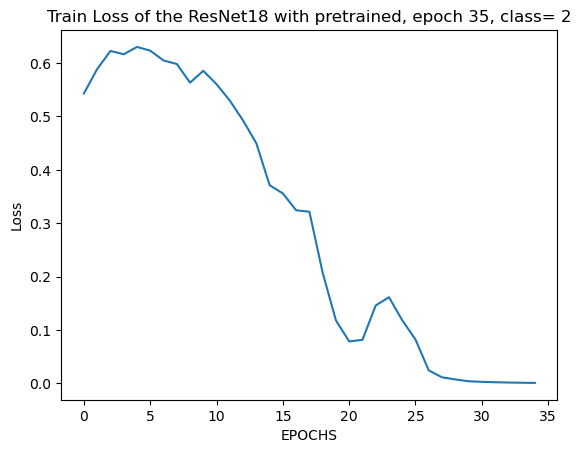

In [9]:
plt.plot(train_loss_list)
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title('Train Loss of the ResNet18 with pretrained, epoch {}, class= 2'.format(EPOCHS))
plt.legend
plt.show()

In [10]:
# from matplotlib import pyplot as plt

# plt.plot(test_f1_list, marker = ' ')
# plt.xlabel("EPOCHS")
# plt.ylabel("F1-Score")
# plt.title('F1-Score binary class')
# plt.show()

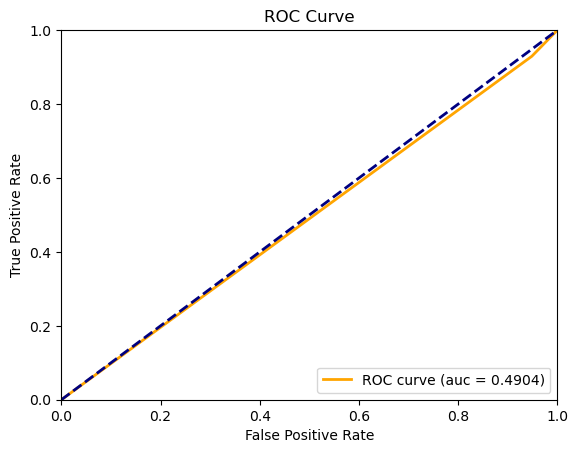

In [11]:
plt.plot(test_fpr_list[-1], test_tpr_list[-1], color='orange', lw=2, label='ROC curve (auc = %0.4f)' % auc(test_fpr_list[-1], test_tpr_list[-1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# from matplotlib import pyplot as plt

# plt.plot(test_auc_list, color = 'navy')
# plt.xlabel("EPOCHS")
# plt.ylabel("AUC Score")
# plt.title('AUC Score_binary')
# plt.show()

# print(auc_score)

In [13]:

# plt.plot(test_acc_list)
# plt.xlabel('EPOCHS')
# plt.ylabel('Accuracy')
# plt.title('Test accuracy of the ResNet18 with pretrained, epoch {}, class= 2'.format(EPOCHS))
# plt.legend
# plt.show()